# TP3 - *Latent Dirichlet Allocation* et Inférence variationnelle 

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse à la méthode "inférence variationnelle" (VI) qui permet d'approcher la loi a posteriori d'un modèle (généralement inconnue) par une autre loi plus simple (généralement un produit de lois bien connues). Nous allons l'appliquer à un modèle probabiliste pour des données textuelles, appelé *Latent Dirichlet Allocation* (LDA, qui n'a rien à voir avec la LDA *Linear Discriminant Analysis* du cours de ML).

### Instructions

1. Renommer votre notebook sous la forme `tp3_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 23 Décembre 2023, 23h59.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl
import scipy as ss

### Partie 0 - Introduction

LDA is a popular probabilistic model for text data, introducted in [Blei et al. (2003)](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf). In this model, the posterior distribution is intractable, and we choose to resort to variational inference (note that a Gibbs sampler would be feasible as well, but would be very slow). In particular, the CAVI updates can be easily derived.

In a few words, in LDA, each document is a mixture of topics, and each topic is a mixture of words. Uncovering those is the goal of *topic modeling*, and this is what we are going to do today. We will be using a collection of abstracts of papers published in JMLR (*Journal of Machine Learning Research*), one of the most prominent journals of the field.

**Check the .pdf file describing the model.**
The posterior is :
$$p(\boldsymbol{\beta}, \boldsymbol{\theta}, \mathbf{z} | \mathcal{D}),$$
which we are going to approximate in the following way :
$$\simeq \left[ \prod_{k=1}^K q(\beta_k) \right] \left[ \prod_{d=1}^D q(\theta_d) \right] \left[ \prod_{d=1}^D \prod_{n=1}^{N_d} q(z_{dn}) \right], $$
with :
* $q(\beta_k)$ a Dirichlet distribution (of size V) with parameter $[\lambda_{k1}, ...,\lambda_{kV}]$
* $q(\gamma_d)$ a Dirichlet distribution (of size K) with parameter $[\gamma_{d1}, ...,\gamma_{dK}]$
* $q(z_{dn})$ a Multinomial distribution (of size K) with parameter $[\phi_{dn1}, ..., \phi_{dnK}]$

The updates are as follows :
* $$\lambda_{kv} = \eta + \sum_{d=1}^D \sum_{n=1}^{N_d} w_{dnv} \phi_{dnk} $$
* $$\gamma_{dk} = \alpha + \sum_{n=1}^{N_d} \phi_{dnk}$$
* $$ \phi_{dnk} \propto \exp \left( \Psi(\gamma_{dk}) + \Psi(\lambda_{k, w_{dn}}) - \Psi(\sum_{v=1}^V \lambda_{kv}) \right)$$

$\Psi$ is the digamma function, use `scipy.special.digamma`.

### Partie 1 - Les données

The data is already prepared, see code below. We have a total of 1898 abstracts.

In [2]:
jmlr_papers = pkl.load(open("jmlr.pkl","rb"))

**Q1.** Fill in a list of keywords from the course, to see how many papers are about probabilistic ML.

In [3]:
bayesian_jmlr_papers = []

for paper in jmlr_papers:
    bayesian_keywords = ["prior", "posterior", "likelihood", "MAP","Bayes"]
    if any([kwd in paper["abstract"] for kwd in bayesian_keywords]):
        bayesian_jmlr_papers.append(paper)
        
print("There are", str(len(bayesian_jmlr_papers))+" Bayesian papers out of", str(len(jmlr_papers)))

There are 467 Bayesian papers out of 1898


Let us now preprocess the data. It is important to remove so-called "stop-words" like a, is, but, the, of, have... Scikit-learn will do the job for us. We will keep only the top-1000 words from the abstracts.

As a result, we get the count matrix $\mathbf{C}$ of size $D = 1898 \times V = 1000$. $c_{dv}$ is the number of occurrences of word $v$ in document $d$. This compact representation is called "bag-of-words". Of course from $\mathbf{C}$ you easily recover the words, since in LDA the order does not matter.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 1000, stop_words='english')
X = vectorizer.fit_transform([paper["abstract"] for paper in jmlr_papers])
print(vectorizer.get_feature_names_out()) # Top-1000 words
C = X.toarray() # Count matrix

# Removing documents with 0 words
idx = np.where(np.sum(C, axis = 1)==0)
C = np.delete(C, idx, axis = 0)

['100' '16' '17' '18' '949' '_blank' 'ability' 'able' 'abs' 'according'
 'account' 'accuracy' 'accurate' 'achieve' 'achieved' 'achieves' 'action'
 'actions' 'active' 'adaboost' 'adaptive' 'addition' 'additional'
 'additive' 'address' 'advantage' 'advantages' 'agent' 'aggregation' 'al'
 'algorithm' 'algorithmic' 'algorithms' 'allow' 'allowing' 'allows'
 'alternative' 'analysis' 'analyze' 'applicable' 'application'
 'applications' 'applied' 'apply' 'applying' 'approach' 'approaches'
 'appropriate' 'approximate' 'approximately' 'approximation'
 'approximations' 'arbitrary' 'art' 'article' 'artificial' 'associated'
 'assume' 'assumed' 'assumption' 'assumptions' 'asymptotic'
 'asymptotically' 'attributes' 'available' 'average' 'averaging' 'bandit'
 'base' 'based' 'basic' 'basis' 'batch' 'bayes' 'bayesian' 'behavior'
 'belief' 'benchmark' 'best' 'better' 'bias' 'bib' 'binary' 'block'
 'boosting' 'bound' 'bounded' 'bounds' 'br' 'build' 'building' 'called'
 'capture' 'carlo' 'case' 'cases' 'ca

**Q2.** How many elements of $\mathbf{C}$ are non-zero ? Is this surprising ?

In [5]:
C.shape

(1895, 1000)

Only 3 documents have been removed out of the 1898. It makes sense since these are theoretical papers which contain a lot of scientifique and specifique terms and we should have at least one of the 1000 most pertinent terms in each document. 
The vocabulary in this corpus of texts is very rich as such it's not suprising that there's more than 1000 words used in these documents which aren't stop words.

### Partie 2 - Inférence variationnelle

As you know from the lecture, VI aims at maximizing the ELBO. I have prepared for you the function to compute the ELBO.

In [6]:
from scipy.special import digamma, loggamma

def ELBO(L, G, phi, a, e, W):
    # Computes the ELBO with the values of the parameters L (Lambda), G (Gamma), and Phi
    # a, e are hyperparameters (alpha and eta)
    # W are the words (obsereved)
    
    # L - K x V matrix (variational parameters Lambda)
    # G - D x K matrix (variational parameters Gamma)
    # phi - List of D elements, each element is a Nd x K matrix (variational parameters Phi)
    # a - Scalar > 0 (hyperparameter alpha)
    # e - Scalar > 0 (hyperparameter eta)
    # W - List of D elements, each element is a Nd x V matrix (observed words)
    
    e_log_B = (digamma(L).T - digamma(np.sum(L, axis = 1))).T
    e_log_T = (digamma(G).T - digamma(np.sum(G, axis = 1))).T
    
    t1 = (e-1)*np.sum(e_log_B)
    t2 = (a-1)*np.sum(e_log_T)

    phi_s = np.zeros((D,K))
    for d in range(0,D):
        phi_s[d,:] = np.sum(phi[d], axis = 0)
    t3 = np.sum(e_log_T*phi_s)
    
    tmp = np.zeros((K,V))
    for d in range(0,D):
        tmp = tmp + np.dot(phi[d].T, W[d])
    t4 = np.sum(e_log_B*tmp)
    
    t5 = np.sum(loggamma(np.sum(L, axis = 1))) - np.sum(loggamma(L)) + np.sum((L-1)*e_log_B)
    t6 = np.sum(loggamma(np.sum(G, axis = 1))) - np.sum(loggamma(G)) + np.sum((G-1)*e_log_T)

    t7 = 0
    for d in range(0,D):
        t7 = t7 + np.sum(phi[d]*np.log(phi[d] + np.spacing(1)))

    return t1 + t2 + t3 + t4 - t5 - t6 - t7

**Q1.** Transform the matrix $\mathbf{C}$ into the observed words $\mathbf{w}$. $\mathbf{w}$ should be a list of $D$ elements, each element of the list being a $N_d \times V$ matrix.

In [7]:
W = []
# On itére sur les documents 
for i in range(C.shape[0]):
    # On initialise la matrice de taille Nd x V
    doc = np.zeros(((C[i]).sum(),C.shape[1]))
    # k compteur pour les lignes qui va aller de 1 à Nd
    k = 0
    for j in range(doc.shape[1]):
        if C[i,j] != 0:
            # Les C[i,j] lignes suivantes seront identiques avec un 1 en j et 0 sinon
            for counts in range(C[i,j]):
                doc[k+counts,j] = 1
            k += C[i,j]
    W.append(doc)

**Q2.** Implement the CAVI algorithm. The updates are given at the beginning of the notebook. Monitor the convergence with the values of the ELBO (but start with a fixed number of iterations, like 50).

* $$\lambda_{kv} = \eta + \sum_{d=1}^D \sum_{n=1}^{N_d} w_{dnv} \phi_{dnk} $$
* $$\gamma_{dk} = \alpha + \sum_{n=1}^{N_d} \phi_{dnk}$$
* $$ \phi_{dnk} \propto \exp \left( \Psi(\gamma_{dk}) + \Psi(\lambda_{k, w_{dn}}) - \Psi(\sum_{v=1}^V \lambda_{kv}) \right)$$

In [8]:
# Paramètres pour les distributions Dirichlet
D =  len(W)
V = 1000
K = 10 
L = np.random.rand(K,V)
G = np.ones((D,K))/K 

In [94]:
def CAVI(W, K, a, e, seed): # Other arguments may be added
    # L - K x V matrix (variational parameters Lambda)
    # G - D x K matrix (variational parameters Gamma)
    # phi - List of D elements, each element is a Nd x K matrix (variational parameters Phi)
    np.random.seed(seed)
    V= 1000
    D =len(W)
    # Initiliase Lambda values
    L = np.random.rand(K,V)
    # Initialise Gamma values
    G = np.ones((D,K))/K 
    # initialise phi
    phi = []
    for d in range(D):
        Nd = len(W[d])
        phi_d = np.zeros((Nd,K))
        for n in range(Nd):
            for k in range(K):
                phi_d[n][k] = np.exp(ss.special.digamma(G[d][k])+ ss.special.digamma(L[k][np.where(W[d][n]==1)[0][0]]) - ss.special.digamma(np.sum(L[k])))
        phi.append(phi_d)
    elbo = ELBO(L, G, phi, a, e, W)
    n_iter = 0
    liste_elbo = [elbo]
    while n_iter <20:
        print(f'iteration: {n_iter}')
        # Update the variables of q
        L = np.full((K,V),e)
        G = np.full((D,K),a)
        for d in range(D):
            L += phi[d][:][:].transpose()@W[d][:][:]
            G[d] += phi[d].sum(axis=0)

        for d in range(len(W)):
            Nd = len(W[d])
            for n in range(Nd):
                for k in range(K):
                    phi[d][n][k] = np.exp(ss.special.digamma(G[d][k])+ ss.special.digamma(L[k][np.where(W[d][n]==1)[0][0]]) - ss.special.digamma(np.sum(L[k])))

        # compute
        res = ELBO(L, G, phi, a, e, W)
        liste_elbo.append(res)
        n_iter += 1
    
    return L, G, phi, liste_elbo

In [28]:
def CAVI_opti(W, K, a, e, seed, max_iter=20): # Other arguments may be added
    # L - K x V matrix (variational parameters Lambda)
    # G - D x K matrix (variational parameters Gamma)
    # phi - List of D elements, each element is a Nd x K matrix (variational parameters Phi)
    np.random.seed(seed)
    V= 1000
    D =len(W)
    # Initiliase Lambda values
    L = np.random.rand(K,V)
    # Initialise Gamma values
    G = np.ones((D,K))/K 
    # initialise phi
    phi = []
    for d in range(D):
        Nd = len(W[d])
        phi_d = np.zeros((Nd, K))
        # Calcul des termes digamma pour G[d]
        digamma_G = ss.special.digamma(G[d])

        for n in range(Nd):
            indices = np.where(W[d][n] != 0)[0]
            phi_d[n] = np.exp(digamma_G + ss.special.digamma(L[:, indices[0]]) - ss.special.digamma(np.sum(L, axis=1)))
            phi_d[n] =  phi_d[n]/np.sum(phi_d[n])
        phi.append(phi_d)

    elbo = ELBO(L, G, phi, a, e, W)
    n_iter = 0
    liste_elbo = np.zeros(max_iter)
    liste_elbo[0] = elbo
    
    while n_iter <max_iter:
        print(f'iteration: {n_iter}')
        # Update the variables of q
        L = np.full((K,V),e)
        G = np.full((D,K),a)
        for d in range(D):
            L += phi[d][:][:].transpose()@W[d][:][:]
            G[d] += np.sum(phi[d],axis=0)


        for d in range(D):
            Nd = len(W[d])
            #phi_d = np.zeros((Nd, K))
            
            # Calcul des termes digamma pour G[d]
            digamma_G = ss.special.digamma(G[d])

            for n in range(Nd):
                indices = np.where(W[d][n] != 0)[0]
                phi[d][n] = np.exp(digamma_G + ss.special.digamma(L[:, indices[0]]) - ss.special.digamma(np.sum(L, axis=1)))
                phi[d][n] =  phi[d][n]/np.sum(phi[d][n])

        # compute
        liste_elbo[n_iter] = ELBO(L, G, phi, a, e, W)
        n_iter += 1
    
    return L, G, phi, liste_elbo

**Q3.** Run the algorithm with $K = 10$, $\alpha = 0.5$, $\eta = 0.1$. From the results, compute the MMSE of $\lambda_{kv}$ and $\gamma_{dk}$.

**Bonus** : Re-run the algorithm several times with different initializations, and keep the solution which returns the highest ELBO.

NB : In my implementation, one iteration of the CAVI algorithm takes about 4 seconds to run.

In [32]:
K = 10
a = 0.5
e = 0.1

L, G, phi, list_ELBO = CAVI_opti(W, K, a, e, 123,max_iter=50)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49


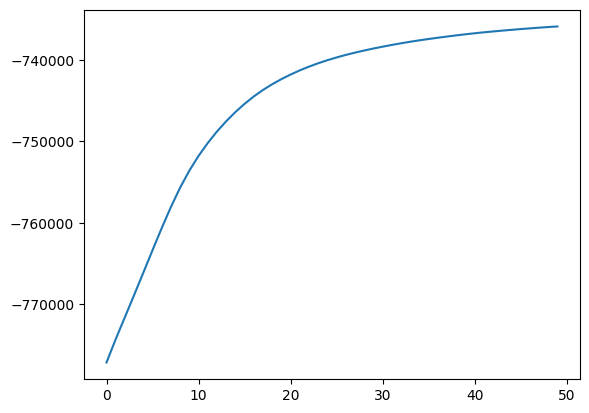

In [34]:
plt.plot(range(50), list_ELBO)
plt.show()

**Q4.** Based on the MMSE estimates :
* What are the top-10 words per topic ? With your machine learning knowledge, can you make sense of some of the topics ?
* Choose one document at random and display its topic proportions. Comment.

In [ ]:
#######
### YOUR CODE HERE
#######

----- Your answer here -----

**Q5.** Open questions :
* What are some limitations of the LDA model ? Can you imagine an improvement ?
* In this notebook, we have treated the hyperparameters as fixed. How could they be learned ?
* Can you imagine a method to choose the number of topics ?
* What strategies should we use to make the algorithm more efficient ?

**BONUS.** Papier-crayon. À partir du modèle, pouvez-vous dériver les lois conditionnelles de l'échantillonneur de Gibbs ? Pour rappel, nous avons besoin de ces lois pour dériver ensuite les updates de l'algorithme CAVI.